In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
import datetime
from sklearn import cluster
from sklearn.preprocessing import scale
from datetime import datetime
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopandas.tools import overlay

sns.set(style="whitegrid")

In [2]:
requests_link = "./data/311_requests.csv"
requests_tmp = pd.read_csv(requests_link)

# almost 18,000 requests are being geocoded to the same place
tmp = requests_tmp.groupby('Latitude').count().sort_values(by='open_dt',ascending=False)

# pull out those requests and take it out for now
odd = requests_tmp.loc[(requests_tmp.Latitude==42.3594) & (requests_tmp.Longitude==-71.0587), ['Longitude', 'Latitude']]
requests = requests_tmp.drop(odd.index)

In [3]:
requests['closed_dt'].fillna(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), inplace=True)

In [4]:
requests['open_dt_date'] = pd.to_datetime(requests['open_dt'], format="%Y-%m-%d %H:%M:%S")
requests['closed_dt_date'] = pd.to_datetime(requests['closed_dt'], format="%Y-%m-%d %H:%M:%S")

In [5]:
requests.dtypes

CASE_ENQUIRY_ID             int64
open_dt                    object
target_dt                  object
closed_dt                  object
OnTime_Status              object
CASE_STATUS                object
CASE_TITLE                 object
SUBJECT                    object
REASON                     object
TYPE                       object
QUEUE                      object
Department                 object
Latitude                  float64
Longitude                 float64
Source                     object
open_dt_date       datetime64[ns]
closed_dt_date     datetime64[ns]
dtype: object

In [6]:
requests['open_len'] = requests['closed_dt_date'] - requests['open_dt_date']
requests['open_len_h'] = requests['open_len'].astype('timedelta64[h]')
print(requests.dtypes)

CASE_ENQUIRY_ID              int64
open_dt                     object
target_dt                   object
closed_dt                   object
OnTime_Status               object
CASE_STATUS                 object
CASE_TITLE                  object
SUBJECT                     object
REASON                      object
TYPE                        object
QUEUE                       object
Department                  object
Latitude                   float64
Longitude                  float64
Source                      object
open_dt_date        datetime64[ns]
closed_dt_date      datetime64[ns]
open_len           timedelta64[ns]
open_len_h                 float64
dtype: object


In [7]:
requests.head(10)

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source,open_dt_date,closed_dt_date,open_len,open_len_h
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App,2017-04-29 00:02:07,2017-05-02 22:18:05,3 days 22:15:58,94.0
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App,2017-04-28 23:55:28,2017-05-02 22:18:05,3 days 22:22:37,94.0
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App,2017-04-28 23:15:15,2017-05-02 22:18:05,3 days 23:02:50,95.0
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App,2017-04-28 23:03:20,2017-05-02 22:18:05,3 days 23:14:45,95.0
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3571,-71.0602,Citizens Connect App,2017-04-28 23:02:50,2017-05-02 22:18:05,3 days 23:15:15,95.0
8,101002075573,2017-04-28 23:02:42,NaN,2017-05-02 22:18:05,ONTIME,Open,Abandoned Bicycle,Mayor's 24 Hour Hotline,Abandoned Bicycle,Abandoned Bicycle,BTDT_District 03,BTDT,42.3269,-71.0870,Citizens Connect App,2017-04-28 23:02:42,2017-05-02 22:18:05,3 days 23:15:23,95.0
9,101002075572,2017-04-28 23:02:40,NaN,2017-05-02 22:18:05,ONTIME,Open,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,Needle Pickup,GEN_Needle_Pickup,GEN_,42.3243,-71.0787,Citizens Connect App,2017-04-28 23:02:40,2017-05-02 22:18:05,3 days 23:15:25,95.0
11,101002075569,2017-04-28 23:02:35,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Requests for Street Cleaning,Public Works Department,Street Cleaning,Requests for Street Cleaning,PWDx_District 06: West Roxbury and Roslindale,PWDx,42.2769,-71.1339,Citizens Connect App,2017-04-28 23:02:35,2017-05-02 22:18:05,3 days 23:15:30,95.0
12,101002075568,2017-04-28 23:02:33,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.0470,Citizens Connect App,2017-04-28 23:02:33,2017-05-02 22:18:05,3 days 23:15:32,95.0
13,101002075567,2017-04-28 23:02:31,2017-05-02 08:30:00,2017-05-02 22:18:05,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3567,-71.0600,Citizens Connect App,2017-04-28 23:02:31,2017-05-02 22:18:05,3 days 23:15:34,95.0


In [8]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(requests.Longitude, requests.Latitude)]
df = requests.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
r_geo = GeoDataFrame(df, crs=crs, geometry=geometry)

In [9]:
cb = gpd.read_file('./data/census2000blockgroups_poly/census2000blockgroups_poly.shp')
suffolk = cb.loc[cb['COUNTY'] == '025']
suffolk = suffolk.to_crs({'init': 'epsg:4326'})

In [10]:
suffolk.head()

,AREA,BG_ID,BLK_COUNT,BLOCKGROUP,COUNTY,CT_ID,DRY_ACRES,DRY_PCT,DRY_SQKM,DRY_SQMI,LOGRECNO,OBJECTID,PERIMETER,SAMP_POP,SHAPE_AREA,SHAPE_LEN,STATE,TOTAL_POP,TRACT,geometry
3801,136944.4990,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,0015169,3824,1532.9773,1004,136945.08470,1532.983397,25,982,000100,POLYGON ((-71.13089703892072 42.36069696794833...
3802,104342.6123,250250001003,11,3,025,25025000100,25.78,1.0,0.10,0.040,0015170,3825,1727.9928,734,104342.61115,1728.000682,25,796,000100,POLYGON ((-71.12965805378326 42.36064499970125...
3803,240201.0853,250250002011,15,1,025,25025000201,59.35,1.0,0.24,0.093,0015173,3827,2013.4407,937,240201.79040,2013.429038,25,905,000201,POLYGON ((-71.16243698749889 42.35631701466854...
3804,178741.8826,250250002013,6,3,025,25025000201,44.17,1.0,0.18,0.069,0015175,3829,2071.7515,1437,178743.19160,2071.748324,25,1406,000201,"POLYGON ((-71.1665479549896 42.35344602168698,..."
3805,80437.8849,250250002014,4,4,025,25025000201,19.88,1.0,0.08,0.031,0015176,3830,1152.7827,759,80435.59485,1152.776511,25,788,000201,POLYGON ((-71.16141198990212 42.34881704289953...


In [11]:
# spatial join requests to blocks
cb_r = gpd.sjoin(suffolk, r_geo, how="inner", op='intersects')
cb_r["count"] = 1

In [12]:
cb_r = cb_r[['BG_ID', 'Department', 'Source', 'open_len_h', 'count', 'geometry']]
cb_r.head()

,BG_ID,Department,Source,open_len_h,count,geometry
3801,250250001002,PWDx,Constituent Call,49.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Constituent Call,191.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Citizens Connect App,1.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Citizens Connect App,8.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Self Service,81.0,1,POLYGON ((-71.13089703892072 42.36069696794833...


In [13]:
pd.set_option('display.max_columns', None)
cb_r_input = pd.get_dummies(cb_r, columns=['Source', 'Department'])
cb_r_input.head()

,BG_ID,open_len_h,count,geometry,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPD_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
3801,250250001002,49.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,191.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,1.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,8.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,81.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
print(cb_r_input.columns)

Index(['BG_ID', 'open_len_h', 'count', 'geometry',
       'Source_Citizens Connect App', 'Source_City Worker App',
       'Source_Constituent Call', 'Source_Employee Generated',
       'Source_Self Service', 'Source_Twitter', 'Department_ANML',
       'Department_BHA_', 'Department_BPD_', 'Department_BPS_',
       'Department_BTDT', 'Department_BWSC', 'Department_DISB',
       'Department_DND_', 'Department_GEN_', 'Department_HS_D',
       'Department_HS_O', 'Department_INFO', 'Department_ISD',
       'Department_ONS_', 'Department_PARK', 'Department_PROP',
       'Department_PWDx'],
      dtype='object')


In [15]:
f = {'open_len_h': ['mean'], 
     'count': ['sum'], 
     'Source_Citizens Connect App': ['sum'], 
     'Source_City Worker App': ['sum'], 
     'Source_Constituent Call': ['sum'], 
     'Source_Employee Generated': ['sum'], 
     'Source_Self Service': ['sum'], 
     'Source_Twitter': ['sum'], 
     'Department_ANML': ['sum'], 
     'Department_BHA_': ['sum'], 
     'Department_BPS_': ['sum'], 
     'Department_BTDT': ['sum'], 
     'Department_BWSC': ['sum'], 
     'Department_DISB': ['sum'], 
     'Department_DND_': ['sum'], 
     'Department_GEN_': ['sum'], 
     'Department_HS_D': ['sum'], 
     'Department_HS_O': ['sum'], 
     'Department_INFO': ['sum'], 
     'Department_ISD': ['sum'], 
     'Department_ONS_': ['sum'], 
     'Department_PARK': ['sum'], 
     'Department_PROP': ['sum'], 
     'Department_PWDx': ['sum'], 
    }

In [16]:
cb_r_input_av = cb_r_input.groupby('BG_ID').agg(f)
cb_r_input_av.head()

,open_len_h,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
BG_ID,,,,,,,,,,,,,,,,,,,,,,,,
250250001001,170.336000,125,42.0,23,45,8,7,0,0,0,0,13,0,0,0,1,0,0,12,4,0,1,4,90.0
250250001002,162.325301,83,26.0,9,37,9,2,0,0,0,0,8,1,0,0,0,0,0,0,12,0,6,0,56.0
250250001003,143.050000,80,47.0,6,20,3,4,0,0,0,0,26,0,0,0,0,0,0,2,4,0,0,4,44.0
250250001004,254.553846,65,25.0,4,27,4,5,0,0,0,0,17,0,0,0,0,0,0,2,10,0,0,5,31.0
250250002011,89.623656,93,31.0,10,41,5,6,0,0,0,0,13,0,0,0,0,0,0,3,1,0,1,0,75.0


In [17]:
# scale before clustering
cb_r_input_av_scale = pd.DataFrame(\
                 scale(cb_r_input_av), \
                 index=cb_r_input_av.index, \
                 columns=cb_r_input_av.columns)\
       .rename(lambda x: str(int(x)))
cb_r_input_av_scale.head()

,open_len_h,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
BG_ID,,,,,,,,,,,,,,,,,,,,,,,,
250250001001,-0.302377,0.656590,0.126704,1.899921,0.439582,1.202907,0.837763,-0.403512,-0.376693,-0.084504,-0.191273,-0.155700,-0.648884,-0.128928,-0.131938,0.052109,-0.042914,-0.060746,2.730930,-0.663396,-0.214834,-0.486632,0.352131,1.084214
250250001002,-0.383097,-0.090510,-0.307996,0.238254,0.032114,1.469784,-0.408117,-0.403512,-0.376693,-0.084504,-0.191273,-0.458851,0.195597,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.869133,0.384933,-0.214834,0.653453,-0.382516,0.078112
250250001003,-0.577327,-0.143874,0.262548,-0.117818,-0.833755,-0.131476,0.090235,-0.403512,-0.376693,-0.084504,-0.191273,0.632495,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.269122,-0.663396,-0.214834,-0.714649,0.352131,-0.276983
250250001004,0.546252,-0.410696,-0.335165,-0.355199,-0.477221,0.135401,0.339411,-0.403512,-0.376693,-0.084504,-0.191273,0.086822,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.269122,0.122851,-0.214834,-0.714649,0.535793,-0.661669
250250002011,-1.115682,0.087371,-0.172152,0.356944,0.235848,0.402277,0.588587,-0.403512,-0.376693,-0.084504,-0.191273,-0.155700,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,0.030883,-1.056519,-0.214834,-0.486632,-0.382516,0.640345


In [18]:
# cluster data
km = cluster.KMeans(n_clusters=5)

In [19]:
kmcls = km.fit(cb_r_input_av_scale.values)

In [20]:
kmcls.labels_

array([0, 0, 4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 0,
       4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 4, 4, 3, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 3,
       3, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 4, 3, 4, 4, 0, 4, 0, 3, 4, 3,
       3, 4, 4, 4, 0, 0, 4, 4, 3, 0, 0, 0, 0, 0, 4, 3, 4, 1, 0, 0, 3, 0, 3,
       1, 4, 3, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 3, 0, 3, 0, 4, 4,
       4, 0, 0, 4, 3, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 3, 4,
       0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 4, 4, 0, 0, 0, 0, 3, 4, 2, 0, 4, 0, 4,
       0, 3, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 3, 0, 0, 1, 0, 3,
       3, 4, 3, 0, 3, 3, 3, 3, 4, 3, 0, 0, 3, 4, 0, 3, 0, 0, 3, 0, 0, 3, 4,
       4, 3, 3, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 0, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 4,
       0, 0, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0,

In [21]:
clusters = cb_r_input_av_scale.assign(cl=kmcls.labels_)

In [22]:
# join back to spatial
geo = suffolk[['BG_ID', 'geometry']]
print(type(geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [23]:
clusters = clusters.reset_index(drop=False)
clusters.columns = clusters.columns.droplevel(-1)
clusters.head()

,BG_ID,open_len_h,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx,cl
0,250250001001,-0.302377,0.656590,0.126704,1.899921,0.439582,1.202907,0.837763,-0.403512,-0.376693,-0.084504,-0.191273,-0.155700,-0.648884,-0.128928,-0.131938,0.052109,-0.042914,-0.060746,2.730930,-0.663396,-0.214834,-0.486632,0.352131,1.084214,0
1,250250001002,-0.383097,-0.090510,-0.307996,0.238254,0.032114,1.469784,-0.408117,-0.403512,-0.376693,-0.084504,-0.191273,-0.458851,0.195597,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.869133,0.384933,-0.214834,0.653453,-0.382516,0.078112,0
2,250250001003,-0.577327,-0.143874,0.262548,-0.117818,-0.833755,-0.131476,0.090235,-0.403512,-0.376693,-0.084504,-0.191273,0.632495,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.269122,-0.663396,-0.214834,-0.714649,0.352131,-0.276983,4
3,250250001004,0.546252,-0.410696,-0.335165,-0.355199,-0.477221,0.135401,0.339411,-0.403512,-0.376693,-0.084504,-0.191273,0.086822,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.269122,0.122851,-0.214834,-0.714649,0.535793,-0.661669,4
4,250250002011,-1.115682,0.087371,-0.172152,0.356944,0.235848,0.402277,0.588587,-0.403512,-0.376693,-0.084504,-0.191273,-0.155700,-0.648884,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,0.030883,-1.056519,-0.214834,-0.486632,-0.382516,0.640345,0


In [24]:
cl_geo = geo.merge(clusters, on='BG_ID')
print(type(cl_geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


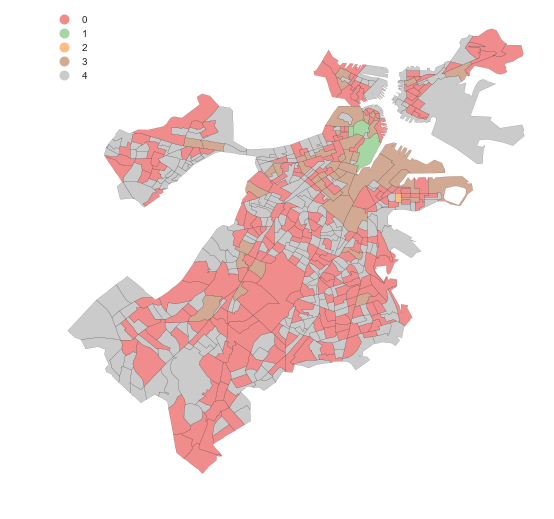

In [25]:
f, ax = plt.subplots(1, figsize=(9, 9))

cl_geo.plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, ax=ax, cmap='Set1')

ax.set_axis_off()

plt.show()

In [26]:
cols = list(cl_geo.ix[:,2:25].columns)
cols

['open_len_h',
 'count',
 'Source_Citizens Connect App',
 'Source_City Worker App',
 'Source_Constituent Call',
 'Source_Employee Generated',
 'Source_Self Service',
 'Source_Twitter',
 'Department_ANML',
 'Department_BHA_',
 'Department_BPS_',
 'Department_BTDT',
 'Department_BWSC',
 'Department_DISB',
 'Department_DND_',
 'Department_GEN_',
 'Department_HS_D',
 'Department_HS_O',
 'Department_INFO',
 'Department_ISD',
 'Department_ONS_',
 'Department_PARK',
 'Department_PROP']

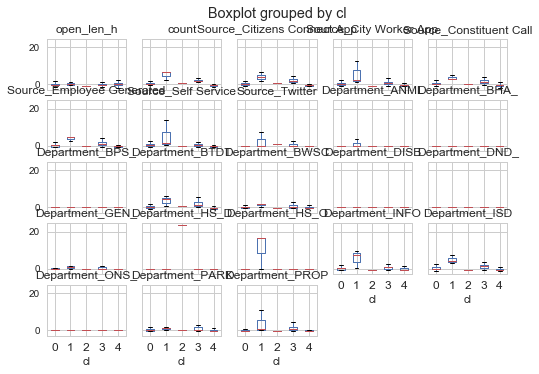

In [27]:
cl_geo.boxplot(cols, 'cl')
plt.show()

In [28]:
cols_subset = ["open_len_h", "count", "Source_Citizens Connect App", "Source_Constituent Call", "Source_Employee Generated",
             "Department_BWSC", "Department_BTDT", "Department_ISD", "Department_PROP", "Department_PARK"]

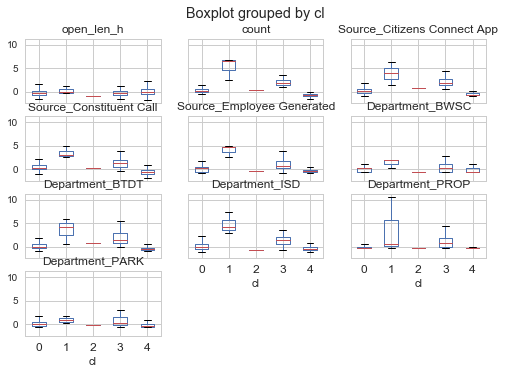

In [29]:
cl_geo.boxplot(cols_subset, 'cl')
plt.show()

In [30]:
open_len_h = cb_r_input.groupby("BG_ID")['open_len_h'].mean()
open_len = pd.DataFrame(open_len_h)
open_len = open_len.reset_index(drop=False)

In [31]:
open_len_geo = geo.merge(open_len, on='BG_ID')
open_len_geo.head()

,BG_ID,geometry,open_len_h
0,250250001002,POLYGON ((-71.13089703892072 42.36069696794833...,162.325301
1,250250001003,POLYGON ((-71.12965805378326 42.36064499970125...,143.050000
2,250250002011,POLYGON ((-71.16243698749889 42.35631701466854...,89.623656
3,250250002013,"POLYGON ((-71.1665479549896 42.35344602168698,...",116.500000
4,250250002014,POLYGON ((-71.16141198990212 42.34881704289953...,174.440000


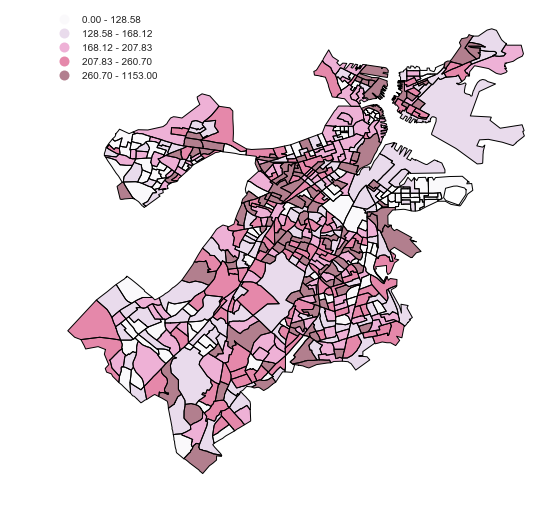

In [32]:
# plot open_len_h
f, ax = plt.subplots(1, figsize=(9, 9))

open_len_geo.plot(column='open_len_h', ax=ax, cmap='PuRd', scheme="Quantiles", legend=True)

ax.set_axis_off()

plt.show()

In [33]:
# write to shapefile in order to create spatial weights
open_len_geo.to_file("./data/open_len_geo/open_len_geo.shp",driver='ESRI Shapefile')

In [34]:
shp_path = "./data/open_len_geo/open_len_geo.shp"
qW = ps.queen_from_shapefile(shp_path, idVariable='BG_ID')
qW.transform = 'r'

In [35]:
qW['250250001003']

{'250250001001': 0.2,
 '250250001002': 0.2,
 '250250001004': 0.2,
 '250250008023': 0.2,
 '250250008024': 0.2}

In [36]:
open_len_geo = open_len_geo.set_index('BG_ID')

In [37]:
self_and_neighbors = ['250250002014']
self_and_neighbors.extend(qW.neighbors['250250002014'])
print(self_and_neighbors)

['250250002014', '250250004023', '250250002022', '250250002013', '250250002023', '250250002012', '250250003021']


In [38]:
open_len_geo.loc[self_and_neighbors]

,geometry,open_len_h
BG_ID,,
250250002014,POLYGON ((-71.16141198990212 42.34881704289953...,174.440000
250250004023,POLYGON ((-71.15399695547927 42.34739700260659...,111.213115
250250002022,POLYGON ((-71.15593397187453 42.35154602890392...,177.314815
250250002013,"POLYGON ((-71.1665479549896 42.35344602168698,...",116.500000
250250002023,POLYGON ((-71.15452797517611 42.35283498601503...,164.500000
250250002012,"POLYGON ((-71.1598980018213 42.35279697618646,...",125.605634
250250003021,POLYGON ((-71.16952202275158 42.34827399647556...,174.104839


In [39]:
qW.pct_nonzero

1.091452205882353

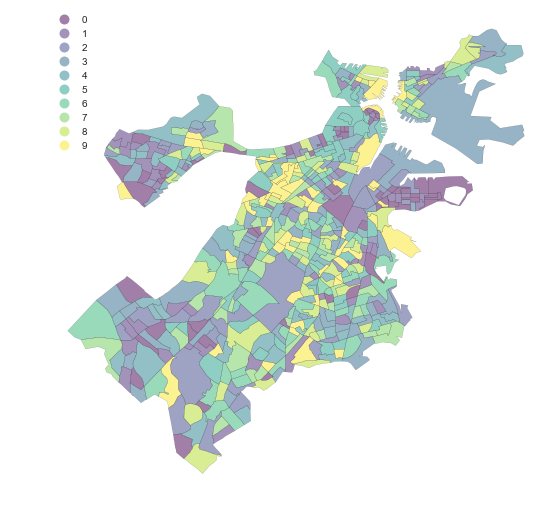

In [40]:
# sim way of showing quantiles
open_len_Q10 = ps.Quantiles(open_len_geo.open_len_h, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
open_len_geo.assign(cl=open_len_Q10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='viridis', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()

In [41]:
# plot spatial lag quantiles 
open_len_lag = ps.lag_spatial(qW, open_len_geo.open_len_h.values)
open_len_lag_Q10 = ps.Quantiles(open_len_lag, k=10)
open_len_lag_Q10

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <= 143.184               55
143.184 < x[i] <= 159.037               54
159.037 < x[i] <= 174.737               54
174.737 < x[i] <= 186.810               55
186.810 < x[i] <= 196.861               54
196.861 < x[i] <= 207.584               54
207.584 < x[i] <= 220.654               55
220.654 < x[i] <= 236.006               54
236.006 < x[i] <= 256.613               54
256.613 < x[i] <= 405.350               55

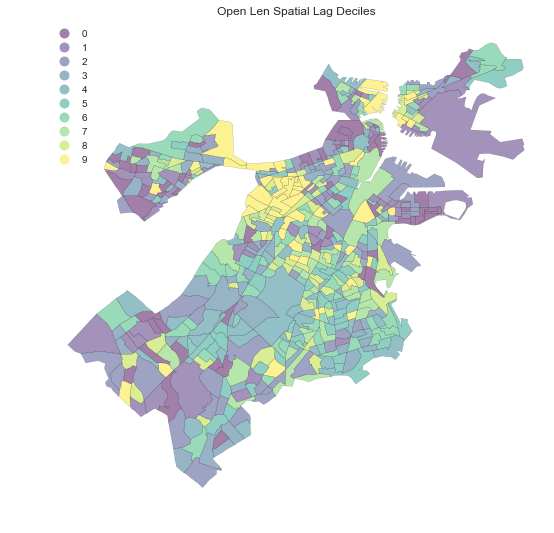

In [42]:
f, ax = plt.subplots(1, figsize=(9, 9))
open_len_geo.assign(cl=open_len_lag_Q10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='viridis', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Open Len Spatial Lag Deciles")
plt.show()

In [43]:
# moran scatter plot
open_len = open_len_geo.open_len_h
b,a = np.polyfit(open_len, open_len_lag, 1)

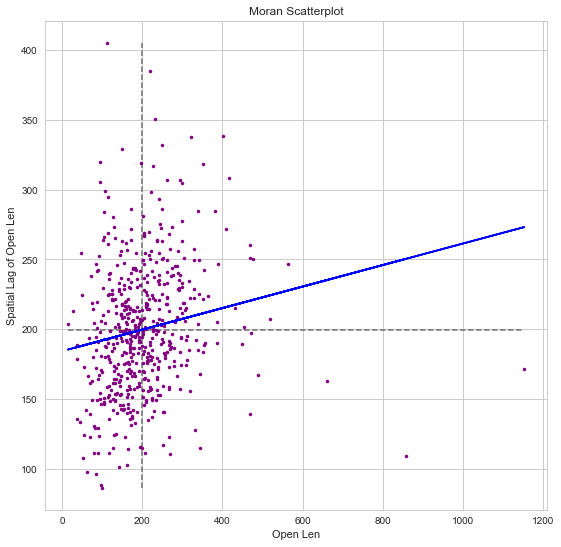

In [44]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(open_len, open_len_lag, '.', color='purple')

 # dashed vert at mean of the last year's PCI
plt.vlines(open_len.mean(), open_len_lag.min(), open_len_lag.max(), linestyle='--', color='grey')
 # dashed horizontal at mean of lagged PCI
plt.hlines(open_len_lag.mean(), open_len.min(), open_len.max(), linestyle='--', color='grey')

# red line of best fit using global I as slope
plt.plot(open_len, a + b*open_len, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Open Len')
plt.xlabel('Open Len')
plt.show()

In [45]:
# global moran's I
I_open_len = ps.Moran(open_len_geo.open_len_h.values, qW)
I_open_len.I, I_open_len.p_sim

(0.077150235883215609, 0.0050000000000000001)

(-0.15, 0.15)

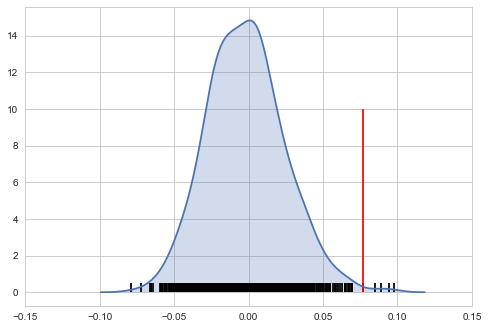

In [46]:
# plot next to simulated runs
sns.kdeplot(I_open_len.sim, shade=True)
plt.vlines(I_open_len.sim, 0, 0.5)
plt.vlines(I_open_len.I, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

In [47]:
LMo_open_len = ps.Moran_Local(open_len_geo.open_len_h.values, qW, permutations=9999)

In [48]:
LMo_open_len.Is[0:10], LMo_open_len.p_sim[0:10]

(array([-0.04014264,  0.57457141,  1.00232714,  0.75935844,  0.16450948,
         0.13636409,  0.058439  ,  0.54658862, -0.45127058,  1.06707952]),
 array([ 0.3108,  0.0116,  0.0041,  0.0214,  0.0296,  0.0566,  0.2852,
         0.0227,  0.0489,  0.0304]))

In [49]:
open_len_lag = ps.lag_spatial(qW, open_len_geo.open_len_h.values)
open_len = open_len_geo.open_len_h.values

sigs = open_len[LMo_open_len.p_sim <= .001]
W_sigs = open_len_lag[LMo_open_len.p_sim <= .001]
insigs = open_len[LMo_open_len.p_sim > .001]
W_insigs = open_len_lag[LMo_open_len.p_sim > .001]
sigs

array([ 198.76804124,   62.05185185,   97.275     ,   99.3853211 ,
        127.45299145,  269.2173913 ,  857.625     ])

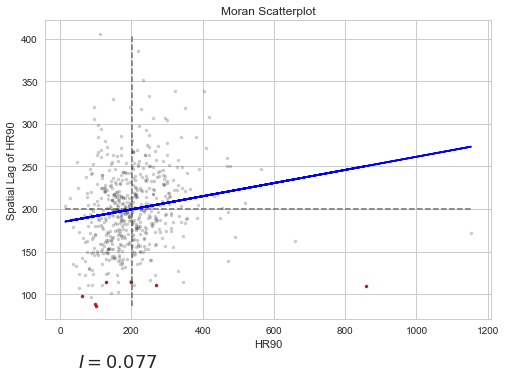

In [50]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(open_len.mean(), open_len_lag.min(), open_len_lag.max(), linestyle='--', color='grey')
 # dashed horizontal at mean of lagged PCI
plt.hlines(open_len_lag.mean(), open_len.min(), open_len.max(), linestyle='--', color='grey')

# red line of best fit using global I as slope
plt.plot(open_len, a + b*open_len, 'b')
plt.text(s='$I = %.3f$' % I_open_len.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

In [51]:
sig = LMo_open_len.p_sim < 0.05
sig.sum()

88

In [52]:
hotspots = LMo_open_len.q==1 * sig
hotspots.sum()

24

In [53]:
coldspots = LMo_open_len.q==3 * sig
coldspots.sum()

41

In [54]:
open_len_geo[hotspots]

,geometry,open_len_h
BG_ID,,
250250101013,POLYGON ((-71.08839605164161 42.34809702512614...,219.275862
250250101015,POLYGON ((-71.09529605800705 42.35069697831376...,231.777778
250250007027,POLYGON ((-71.13278405434919 42.35066300274374...,299.768595
250250008011,POLYGON ((-71.12379699650245 42.35909701972528...,241.243902
250250101021,POLYGON ((-71.09839602457583 42.35119697423344...,220.619048
250250103001,POLYGON ((-71.09329598457481 42.33339702204235...,380.261905
250250104012,POLYGON ((-71.08938401371982 42.34526896106138...,322.282258
250250104013,POLYGON ((-71.08787198001777 42.34357001238417...,293.047619
250250104014,POLYGON ((-71.08669503261311 42.34139698354306...,248.852941


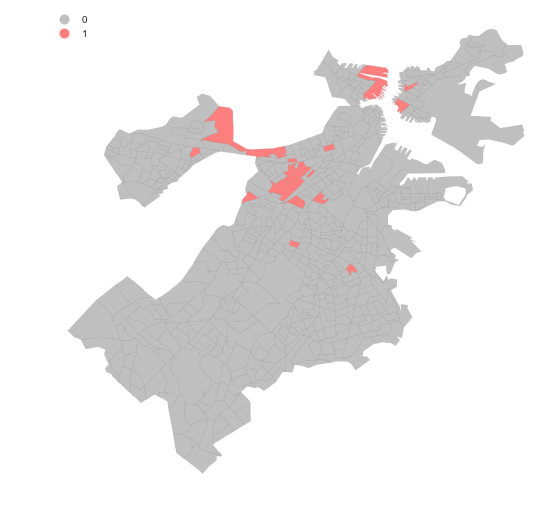

In [55]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
open_len_geo.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

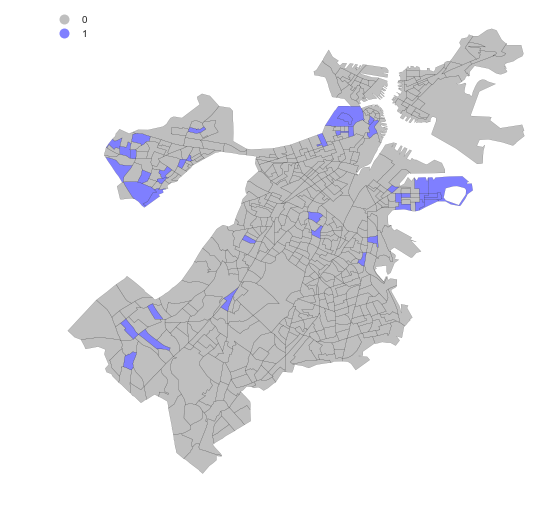

In [56]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
open_len_geo.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

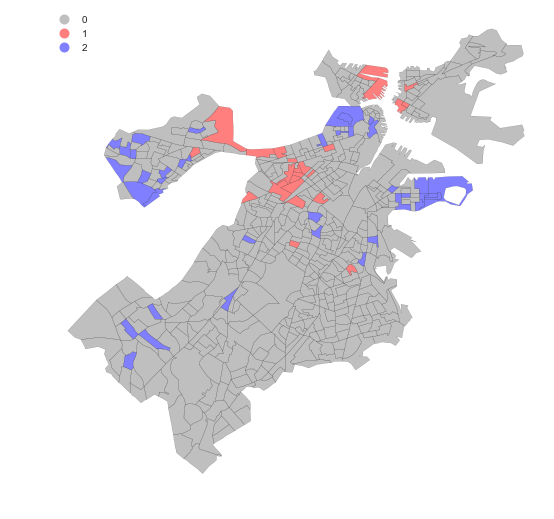

In [57]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
open_len_geo.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()